# Segmentando clientes

experimento colaborativo

## Resumen, explicación del experimento

- tomo seis meses desde enero a junio de 2021
- uso bajas binarias (baja+1 y baja+2 vs continua)
- hago dos conjuntos 8000/2000 de casos uno con mayoria continua y otro con mayoría bajas.
- calculo la **distancia random forest** 
- calculo los clusters con hdbscan 
- obetngo medioides, los puntos reales más cercanos a los centroides
- por problemas de memoria en el próximo paso divido en lotes el dataset grande
- calculo las distancias random forest a esos medioides puntos de todo el dataset - *para toda la competenca*
- asigno cluster a cada punto según medioide más cercano
- hago esto en ambos conjuntos (mayoría bajas y mayoría continua)

- agrego las distancias calculadas al datset antes deL Feature Engeneering
- comparo resultados contra el pipeline estandar

En i5-4690K con 32 de RAM tarda ~ 40 minutos en calcular y 25 minutos en grabar + 10 minutos si queremos graficos para mirar que anda pasando


#### Configuración inicial

In [1]:
#%pip install scikit-learn==1.3.2
#%pip install seaborn==0.13.1
#%pip install numpy==1.26.4
#%pip install matplotlib==3.7.1
# %pip install umap
# %pip install umap-learn # en windows solo instalar umap-learn

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import sys
import polars as pl

from umap import UMAP
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.cluster import HDBSCAN
from sklearn.ensemble import  RandomForestClassifier
from sklearn.impute import SimpleImputer
from scipy.spatial import distance

### dicc de funciones

**armo_seleccion**: elijo cantidad de enfermos y continua para entrenar los modelos

**entreno_modelo**: en un modelo random forest de 200 arboles clasifica los puntos para encontrar las distancias rf

**distanceMatrix**: computo las distancias para el armado de clusters

**centroides_punto**: se usa en la funcion de grafico para ubicar centroides (fue antes de usar hdbscan)

**grafico_clusters**: grafica segun las etiquetas en una proyección umap da una idea remota de como se están armando los clusters

**restart_line**: reinicia la linea para el contador de avance de la funcion de distancias cuando uso lotes

**generar_lotes**: arma los lotes para la funcion de distancias cuando uso lotes

**calcular_proximidad_centroides**: toma puntos del df original y devuenlve las distancias a los centroides

**distancias_para_todos**: acomoda los datos para el calculo de proximidad y divide por lotes si hace falta

**a_df_para_unir**: prepara las distancias a los centroides y los datos de cluster para unir

**guardo_todo**: une los df con el original y guarda. pongo acá para que no se duplique todo en memoria siquiero seguir haciendo cosas


In [26]:
# Función para ubicar centroides en el grafico desde el umap y el dbscan
# util para gráfico y para medir distancia después

def centroides_punto(y, embedding_rf, sin_ruido=True):
    # Asignar las etiquetas de los clusters del DBSCAN
    labels = y
    
    # Crear un DataFrame con las etiquetas y los puntos
    df_clusters = pd.DataFrame(embedding_rf, columns=['x', 'y'])
    df_clusters['cluster'] = labels
    
    # Agrupar por cluster y calcular el centroide (media) de cada uno
    centroides = df_clusters.groupby('cluster').mean()

    # Cantidad de puntos por clúster
    cantidad = pd.Series(labels).value_counts()
    cantidad.index.rename('cluster', inplace=True)
    
    # Unir centroides con la cantidad de puntos por clúster
    centro_y_cantidad = pd.merge(centroides, cantidad, left_index=True, right_index=True)
    centro_y_cantidad.columns = ['centro_x', 'centro_y', 'count']

    if np.isin(-1, labels):
        # Filtrar ruido (clúster -1), si es necesario
        if sin_ruido:
            centro_y_cantidad = centro_y_cantidad[centro_y_cantidad['count'] > centro_y_cantidad.loc[-1, 'count']]
        else:
            centro_y_cantidad = centro_y_cantidad[centro_y_cantidad['count'] != centro_y_cantidad.loc[-1, 'count']]
    
    # Encontrar el punto más cercano al centroide para cada clúster
    punto_mas_cercano = {}
    for cluster in centro_y_cantidad.index:
        # Filtrar los puntos que pertenecen al clúster actual
        puntos_cluster = df_clusters[df_clusters['cluster'] == cluster]
        
        # Coordenadas del centroide del clúster
        centroide = centro_y_cantidad.loc[cluster, ['centro_x', 'centro_y']].values
        
        # Calcular la distancia de cada punto al centroide
        distancias = distance.cdist(puntos_cluster[['x', 'y']], [centroide], metric='euclidean').flatten()
        
        # Obtener el índice del punto más cercano
        indice_cercano = np.argmin(distancias)
        
        # Guardar el punto más cercano al centroide
        punto_mas_cercano[cluster] = puntos_cluster.iloc[indice_cercano]

    indice_punto = []
    p_x = []
    p_y = []
    for i in punto_mas_cercano:
        indice_punto.append(punto_mas_cercano[i].name)
        p_x.append(punto_mas_cercano[i].x)
        p_y.append(punto_mas_cercano[i].y)

    centro_y_cantidad['indice_punto'] = indice_punto
    centro_y_cantidad['p_x'] = p_x
    centro_y_cantidad['p_y'] = p_y
    return centro_y_cantidad

# función para graficar y entender la distribución y cantidades de los clusters
def grafico_clusters(y, embedding_rf, prob_baja, sin_ruido=False):
    
    fig, axs = plt.subplots(1,2, figsize=(16,8))
    
    scatter = axs[0].scatter(embedding_rf[:, 0], embedding_rf[:, 1], c=y, cmap='tab20', s=5, alpha=0.5)
    # produce a legend with the unique colors from the scatter
    legend1 = axs[0].legend(*scatter.legend_elements(),
                        loc="upper left", title="Grupo")
    axs[0].add_artist(legend1)
    axs[0].set_title('Grupos detectados')
    
    prop = axs[1].scatter(embedding_rf[:,0], embedding_rf[:,1], c=prob_baja, s=10,  cmap='bwr', alpha=0.2)
    fig.colorbar(prop, ax=axs[1] )
    axs[1].set_title('Probabilidad de baja')
    
    axs[0].set_xticks([])
    axs[0].set_yticks([])
    axs[1].set_xticks([])
    axs[1].set_yticks([])
    
    centers = centroides_punto(y, embedding_rf, sin_ruido=sin_ruido)
    
    # Draw white circles at cluster centers
    axs[0].scatter(
        centers['centro_x'],
        centers['centro_y'],
        marker="o",
        c="white",
        alpha=1,
        s=150,
        edgecolor="k",
    )
    
    for i, c in enumerate(centers.T):
    
        axs[0].scatter(centers.T[c]['centro_x'], centers.T[c]['centro_y'], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")
    
    fig.tight_layout()
    #fig.savefig('clusters.png', dpi=92)
    plt.show()


def entreno_modelo(Xtrain, ytrain):
    model = RandomForestClassifier(n_estimators=200, max_features=20, max_depth=4, min_samples_leaf=400, random_state=17 )
    model.fit(Xtrain, ytrain)
    return model

def distanceMatrix(model, X):

    terminals = model.apply(X)
    nTrees = terminals.shape[1]

    a = terminals[:,0]
    proxMat = 1*np.equal.outer(a, a)

    for i in range(1, nTrees):
        a = terminals[:,i]
        proxMat += 1*np.equal.outer(a, a)

    proxMat = proxMat / nTrees

    return proxMat.max() - proxMat

def armo_seleccion(Xtrain, ytrain, cant_cont, cant_enf):
    
    np.random.seed(17) 
    continua_sample = ytrain[ytrain == 0].sample(cant_cont).index
    bajas_1_2 = ytrain[ytrain == 1].sample(cant_enf).index
    rf_index = continua_sample.union(bajas_1_2)
    
    Xtrain_rf = Xtrain.loc[rf_index]
    ytrain_rf = ytrain.loc[rf_index]
    
    imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')
    Xtrain_rf_imp = imp_mean.fit_transform(Xtrain_rf.iloc[:,2:]) # saco numero de cliente y foto-mes
    return Xtrain_rf_imp, ytrain_rf, Xtrain_rf, imp_mean



# armos funciones de loop y lotes para procesar todo el dataset.
# hay que ver que onda cuano queramos correr más meses

def a_df_para_unir(distancias_centroides, custer_por_cerc, sufijo='enf'):
    cols =[]
    for col in range(distancias_centroides.shape[1]):
        cols.append(f'clust_{sufijo}_{col}')
    
    df_clus = pd.DataFrame(distancias_centroides, columns=cols)
    df_clus[f'clust_{sufijo}'] = custer_por_cerc
    return df_clus

def restart_line():
    sys.stdout.write('\r')
    sys.stdout.flush()

def generar_lotes(puntos, tamaño_lote):
    """
    Divide los puntos en lotes más pequeños para procesar.
    
    :param puntos: Array o DataFrame con todos los puntos
    :param tamaño_lote: Tamaño de cada lote
    :yield: Un lote de puntos
    """
    for i in range(0, len(puntos), tamaño_lote):
        yield puntos[i:i + tamaño_lote]

# acá calculo la distancia random forest (en el modelo que entrené antes)
# la diferencia es que permite dos grupos de puntos

def calcular_proximidad_centroides(model, puntos_nuevos, centroides):
    """
    Calcula la proximidad basada en bosques aleatorios entre puntos nuevos y los centroides.

    :param model: Modelo de bosque aleatorio (RandomForest) ya entrenado
    :param puntos_nuevos: DataFrame o array con los puntos nuevos (n_rows, n_dims)
    :param centroides: DataFrame o array con los centroides (6, n_dims)
    
    :return: DataFrame con la proximidad entre cada punto nuevo y cada uno de los centroides
    """
    
    # Aplicar el modelo a los puntos nuevos y los centroides para obtener las hojas terminales
    terminales_nuevos = model.apply(puntos_nuevos)
    terminales_centroides = model.apply(centroides)
    # Elimino columnas de puntos duplicados después de rf
    terminales_centroides = np.unique(terminales_centroides, axis=0)
    
    # Obtener el número de árboles en el modelo
    nTrees = terminales_nuevos.shape[1]
    
    # Inicializar la matriz de proximidad
    proximidad = np.zeros((puntos_nuevos.shape[0], terminales_centroides.shape[0]))
    
    # Calcular la proximidad entre cada punto nuevo y cada centroide
    for i in range(nTrees):
        # Compara los terminales de los puntos nuevos con los terminales de los centroides para cada árbol
        iguales = np.equal.outer(terminales_nuevos[:, i], terminales_centroides[:, i])
        proximidad += iguales
   
    # Normalizar por el número de árboles
    proximidad = proximidad / nTrees

    return proximidad.max() - proximidad

# Encapsulo la función anterior preparando el dataset general


def distancias_para_todos(df_base, centroides, model, imp_mean, clase_ternaria=False, tamaño_lote=0):
    if clase_ternaria:
        df_base = df_base.drop("clase_ternaria", axis=1)
    df_base = df_base.iloc[:,2:]
    
     # saco numero de cliente y fotomes
    centroides = imp_mean.transform(centroides.iloc[:,2:])
        
    if tamaño_lote != 0:

        acumulador_distancias = []
        cont = 0
        total = len(df_base.iloc[:,:-1])
    
        for lote_puntos in generar_lotes(df_base, tamaño_lote):

            todos_los_puntos = imp_mean.transform(lote_puntos)

            #contador
            cont = cont + tamaño_lote
            perc = (cont/total)*100       
            sys.stdout.write(f'porcentaje:{perc:,.01f}')
            sys.stdout.flush()
            restart_line()

            distancias_lote = calcular_proximidad_centroides(model, todos_los_puntos, centroides)

            
            acumulador_distancias.append(distancias_lote)

        return np.vstack(acumulador_distancias)
            
    else:
        todos_los_puntos = imp_mean.transform(df_base) # saco numero de cliente y fotomes
        distancias_centroides = calcular_proximidad_centroides(model, todos_los_puntos, centroides)
    
    return distancias_centroides


In [4]:
base_path = 'E:/Users/Piquelin/Documents/Maestría_DataMining/Economia_y_finanzas/'
#base_path = 'C:/Users/jfgonzalez/Documents/documentación_maestría/economía_y_finanzas/'
# base_path = '~/buckets/b1/'
dataset_path = base_path + 'datasets/'
modelos_path = base_path + 'modelos/'
db_path = base_path + 'db/'
dataset_file = 'competencia_01.csv'
dataset_file = 'resultado_sin_prestamos.csv'
dataset_file = 'competencia_02.parquet'
# dataset_file_2 = 'C:/Users/jfgonzalez/Documents/documentación_maestría/economía_y_finanzas/exp/expw_TS-0002_dataset_train_final.csv.gz'

In [5]:
# df_base = pd.read_csv(dataset_path + dataset_file, low_memory=False)
df_base = pd.read_parquet(dataset_path + dataset_file)

In [6]:
# df_base = pd.read_csv(dataset_file_2)

#### empiezo

In [7]:
#Xtrain = df_base[df_base['foto_mes'].isin([202101, 202102, 202103, 202104, 202105, 202106])]
Xtrain = df_base[df_base['foto_mes'].isin([202104, 202103, 202102, 202101, 202012, 202011, 202010, 202009, 202008, 202007, 202005, 202004])]

A su vez, nos concentraremos en el fenómeno de la **baja**. No importa si es en un mes o si es en dos.

In [8]:
#ytrain = Xtrain["clase_ternaria"].map(lambda x: 0 if x == "CONTINUA" else 1)

# elijo solo baja+2
ytrain = Xtrain["clase_ternaria"].map(lambda x: 1 if x == "BAJA+2" else 0)

Xtrain = Xtrain.drop("clase_ternaria", axis=1)

In [9]:
ytrain.value_counts()

clase_ternaria
0    1898292
1       8480
Name: count, dtype: int64

In [28]:
%%time

# Selección de enfermos
Xtrain_enf, ytrain_enf, X_para_medioid_enf, imp_mean_enf= armo_seleccion(Xtrain, ytrain, cant_cont=2000, cant_enf=8000)
# Selección de continua
Xtrain_con, ytrain_con, X_para_medioid_con, imp_mean_con = armo_seleccion(Xtrain, ytrain, cant_cont=8000, cant_enf=8000)


CPU times: total: 2.05 s
Wall time: 1.96 s


In [29]:
%%time
# entreno modelos random forest para enfermos y continua
# además del modelo calculo las matrices de distancias para hacer el clustering

model_enf = entreno_modelo(Xtrain_enf, ytrain_enf) 
md_enf = distanceMatrix(model_enf, Xtrain_enf)
model_con = entreno_modelo(Xtrain_con, ytrain_con) 
md_con = distanceMatrix(model_con, Xtrain_con)


CPU times: total: 4min 11s
Wall time: 4min 20s


Por la alta dimensionalidad (10.000 columnas) uso hdbscan que explora buscando cluisters de densidad variable

In [12]:
%%time
# busco clusters entre enfermos, en la máquina de casa tarda 15~16 minutos
hdb_enf = HDBSCAN(min_cluster_size=20, min_samples=30, n_jobs=-1, store_centers='both')
y_enf = hdb_enf.fit(md_enf)

CPU times: total: 15min 9s
Wall time: 9min 27s


In [30]:
%%time
# busco clusters entre continua, en la máquina de casa tarda 15~16 minutos
hdb_con = HDBSCAN(min_cluster_size=20, min_samples=30, n_jobs=-1, store_centers='both')
y_con = hdb_con.fit(md_con)

CPU times: total: 53min 55s
Wall time: 37min 56s


In [14]:
%%time
# paso de mediodes en el modelo a casos reales

medioid_enf = hdb_enf.medoids_
# Encontrar las filas en matriz_10000 que coinciden con alguna fila en 'puntos'
indices_enf = [i for i in range(md_enf.shape[0]) if any(np.array_equal(md_enf[i], fila) for fila in medioid_enf)]
# me puede devolver más de los mediodes reales por puntos superpuestos, que sean siempre clasificados en el mismo punto.
# por ahora los tomo (no son muchos) y los filtro más adelante
print("Índices de las filas coincidentes:", indices_enf)
medioid_enf = X_para_medioid_enf.iloc[indices_enf]
del indices_enf

Índices de las filas coincidentes: [1305, 4542, 5154, 6924, 7010, 7871, 8948, 9071, 9181, 9535]
CPU times: total: 719 ms
Wall time: 706 ms


In [31]:
%%time
# paso de mediodes en el modelo a casos reales

medioid_con = hdb_con.medoids_
# Encontrar las filas en matriz_10000 que coinciden con alguna fila en 'puntos'
indices_con = [i for i in range(md_con.shape[0]) if any(np.array_equal(md_con[i], fila) for fila in medioid_con)]
# me puede devolver más de los mediodes reales por puntos superpuestos, que sean siempre clasificados en el mismo punto.
# por ahora los tomo (no son muchos) y los filtro más adelante
print("Índices de las filas coincidentes:", indices_con)
medioid_con = X_para_medioid_con.iloc[indices_con]
del indices_con

Índices de las filas coincidentes: [2319, 2436, 3277, 3558, 3570, 3571, 3572, 4175, 4410, 4444, 5142, 5660, 6468, 6698, 7916, 8176, 8215, 8234, 8481, 8792, 9345, 10947, 11318, 11437, 11447, 12795, 13358, 13647, 14238, 14622, 15405, 15618, 15853]
CPU times: total: 3.31 s
Wall time: 3.37 s


In [16]:
%%time
#sin visualizacion calculo distancias y asigno clusters para todo el dataset
distancias_centroides_enf = distancias_para_todos(df_base, medioid_enf, model_enf, imp_mean_enf,  clase_ternaria=True, tamaño_lote=10000)
custer_por_cerc_enf = np.argmin(distancias_centroides_enf, axis=1)

df_clus_enf = a_df_para_unir(distancias_centroides_enf, custer_por_cerc_enf, sufijo='enf')
df_clus_enf.head()

CPU times: total: 2min 7s
Wall time: 2min 9s


,clust_enf_0,clust_enf_1,clust_enf_2,clust_enf_3,clust_enf_4,clust_enf_5,clust_enf_6,clust_enf_7,clust_enf
0,0.940,0.935,0.930,0.910,0.655,0.925,0.865,0.850,4
1,0.895,0.865,0.895,0.755,0.560,0.895,0.930,0.930,4
2,0.935,0.910,0.855,0.915,0.870,0.880,0.775,0.420,7
3,0.855,0.825,0.925,0.655,0.660,0.880,0.935,0.910,3
4,0.940,0.930,0.925,0.895,0.650,0.920,0.900,0.875,4


In [32]:
%%time
#sin visualizacion calculo distancias y asigno clusters para todo el dataset
distancias_centroides_con = distancias_para_todos(df_base, medioid_con, model_con, imp_mean_con,  clase_ternaria=True, tamaño_lote=10000)
custer_por_cerc_con = np.argmin(distancias_centroides_con, axis=1)

df_clus_con = a_df_para_unir(distancias_centroides_con, custer_por_cerc_con, sufijo='con')

df_clus_con.head()

CPU times: total: 2min 40s
Wall time: 2min 44s


,clust_con_0,clust_con_1,clust_con_2,clust_con_3,clust_con_4,clust_con_5,clust_con_6,clust_con_7,clust_con_8,clust_con_9,clust_con_10,clust_con_11,clust_con_12,clust_con_13,clust_con_14,clust_con_15,clust_con_16,clust_con_17,clust_con
0,0.965,0.940,0.965,0.965,0.965,0.965,0.965,0.965,0.965,0.965,0.965,0.950,0.895,0.955,0.930,0.785,0.870,0.465,17
1,0.915,0.815,0.900,0.935,0.890,0.885,0.925,0.925,0.930,0.925,0.905,0.745,0.405,0.920,0.915,0.935,0.955,0.935,12
2,0.965,0.950,0.965,0.965,0.965,0.965,0.965,0.965,0.965,0.960,0.940,0.965,0.960,0.945,0.880,0.925,0.670,0.945,16
3,0.900,0.695,0.875,0.870,0.880,0.890,0.885,0.880,0.890,0.880,0.850,0.610,0.455,0.915,0.945,0.945,0.960,0.945,12
4,0.965,0.925,0.965,0.965,0.965,0.965,0.965,0.965,0.965,0.965,0.965,0.945,0.800,0.965,0.925,0.805,0.895,0.690,17


##### Guardo

In [49]:
%%time
def guardo_todo(df_base, df_clus_enf, df_clus_con, dataset_path):

    nueva_base = pd.concat([df_base, df_clus_enf, df_clus_con], axis=1)
    nueva_base.to_csv(dataset_path + 'competencia_02_clust2.csv.gz', compression='gzip')
    nueva_base.to_parquet(dataset_path + 'competencia_02_clust2.parquet')
    print('listo')
    return None

guardo_todo(df_base, df_clus_enf, df_clus_con, dataset_path)

listo
CPU times: total: 22min 20s
Wall time: 22min 27s


## Gráficos

CPU times: total: 4min 7s
Wall time: 4min 8s


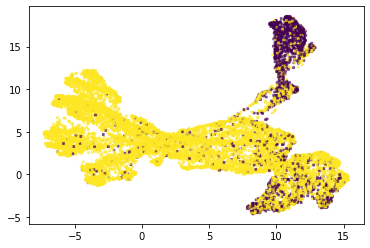

In [19]:
%%time
# este paso es para graficar y ver que está pasando no es necesario si no queremos gráficos
# Separo el fit del transform para mayor claridad
umap_enf = UMAP(
  n_components=2,
  n_neighbors=150,
  min_dist=0.6,
  metric="euclidean", #  precomputed no permite convertir nuevos puntos
  random_state=17,
  n_jobs=1 # porque fijo semilla
).fit(md_enf)

embedding_enf = umap_enf.embedding_

plt.scatter(embedding_enf[:,0], embedding_enf[:,1], c=ytrain_enf, s=5, alpha=0.7, marker='x')



CPU times: total: 11min 23s
Wall time: 11min 39s


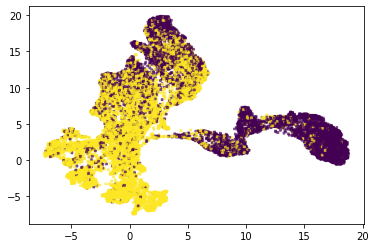

In [33]:
%%time

# Separo el fit del transform para mayor claridad
umap_con = UMAP(
  n_components=2,
  n_neighbors=150,
  min_dist=0.6,
  metric="euclidean", #  precomputed no permite convertir nuevos puntos
  random_state=17,
  n_jobs=1 # porque fijo semilla
).fit(md_con)

embedding_con = umap_con.embedding_

plt.scatter(embedding_con[:,0], embedding_con[:,1], c=ytrain_con, s=5, alpha=0.7, marker='x')



In [44]:
%%time
#también solo útil para graficos
def probabilidad_de_baja(model, Xtrain):
    class_index = np.where(model.classes_ == 1)[0]
    prob_baja = model.predict_proba(Xtrain)[:,class_index]
    return prob_baja

prob_baja_enf = probabilidad_de_baja(model_enf, Xtrain_enf)
prob_baja_con = probabilidad_de_baja(model_con, Xtrain_con)


CPU times: total: 188 ms
Wall time: 189 ms


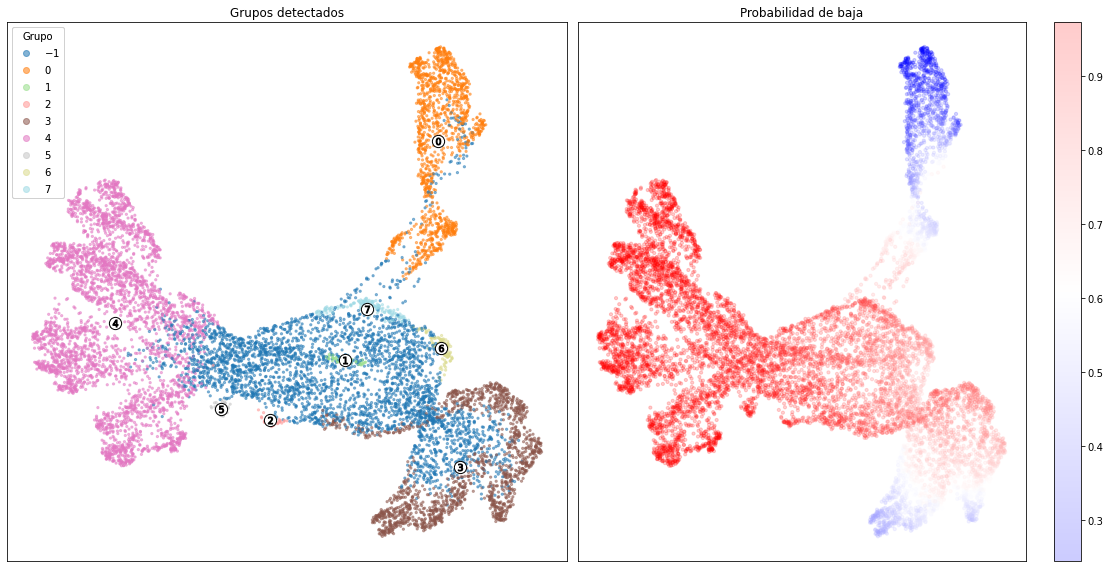

CPU times: total: 656 ms
Wall time: 651 ms


In [47]:
%%time
# separo el grafico por si eligo hacerlo ciego
grafico_clusters(y_enf.labels_, embedding_enf, prob_baja_enf, sin_ruido=False)

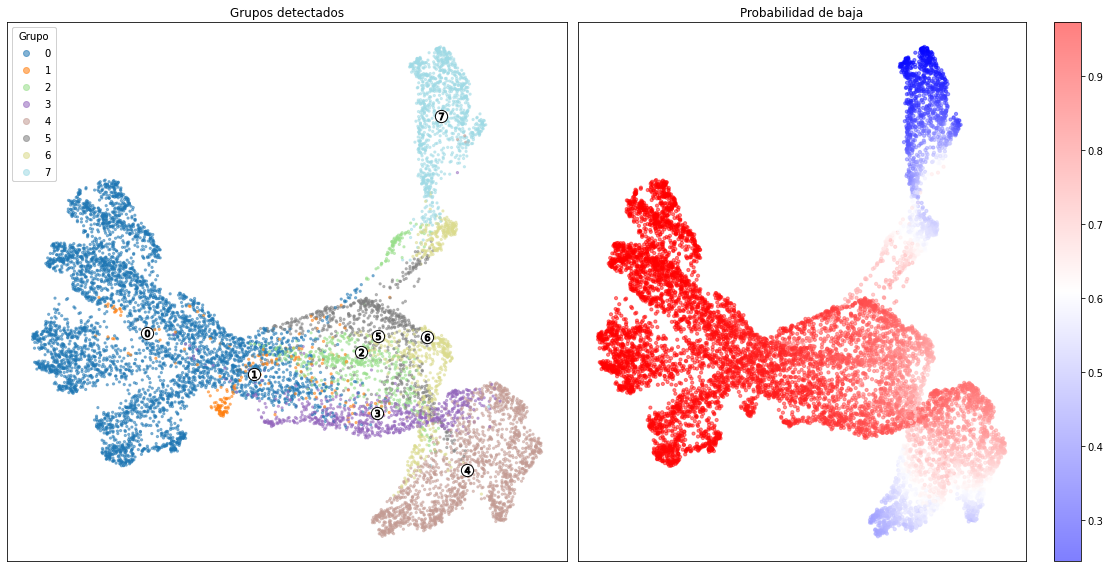

CPU times: total: 891 ms
Wall time: 909 ms


In [23]:
%%time
# para ver con dataset chico
# finalmente calculo el primer set de distancias randomf forest con los puntos más cercanos a los centroides
distancias_centroides_enf = distancias_para_todos(X_para_medioid_enf , medioid_enf, model_enf, imp_mean_enf)
custer_por_cerc_enf = np.argmin(distancias_centroides_enf, axis=1)
grafico_clusters(custer_por_cerc_enf, embedding_enf, prob_baja_enf, sin_ruido=False) 
# oportunidad de mejora contrastar con el anterior

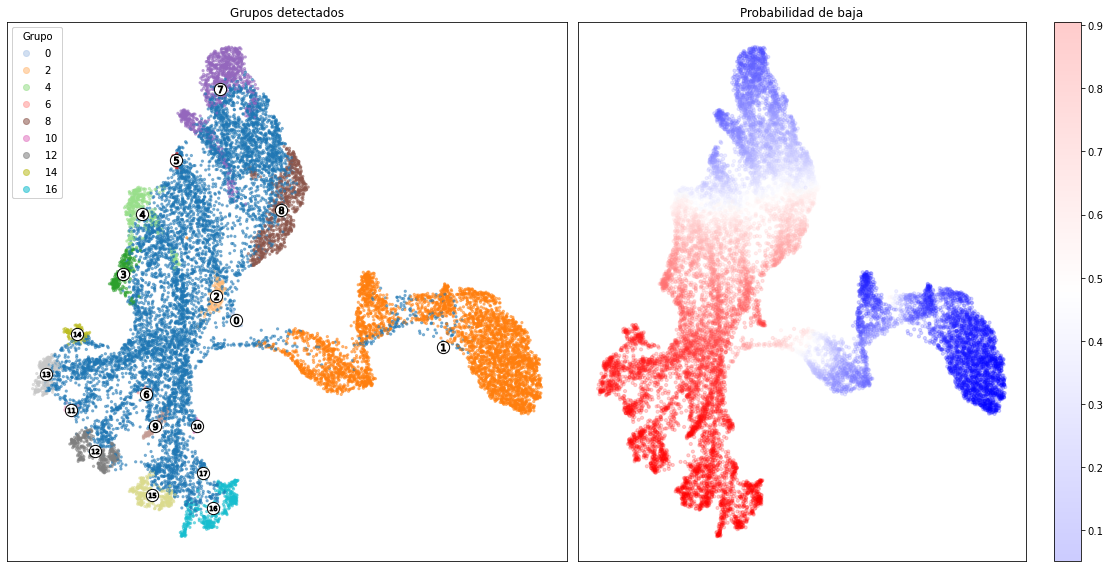

CPU times: total: 984 ms
Wall time: 1.03 s


In [45]:
%%time
# separo el grafico por si eligo hacerlo ciego
grafico_clusters(y_con.labels_, embedding_con, prob_baja_con, sin_ruido=False)

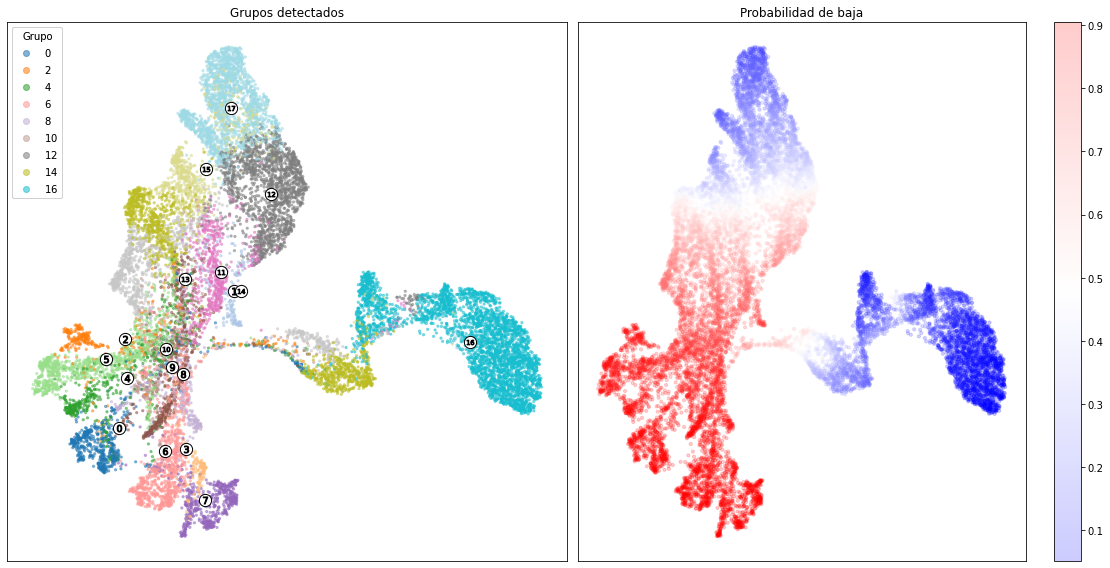

CPU times: total: 1.48 s
Wall time: 1.48 s


In [46]:
%%time
# para ver con dataset chico
# finalmente calculo el primer set de distancias randomf forest con los puntos más cercanos a los centroides
distancias_centroides_con = distancias_para_todos(X_para_medioid_con , medioid_con, model_con, imp_mean_con)
custer_por_cerc_con = np.argmin(distancias_centroides_con, axis=1)
grafico_clusters(custer_por_cerc_con, embedding_con, prob_baja_con, sin_ruido=False) 
# oportunidad de mejora contrastar con el anterior